# Creating regressors and design matrices for fMRI tasks

This unit covers
* How basic regressors are made for fMRI models
* Modulated regressors
* Brief overview of modeling response times (RTs)
* Adding the temporal derivative regressors
* Assessing collinearity in your design matrix


This covers a lot of material and if you'd like to go through it more slowly, I have a series of videos on level 1 modeling (time series modeling) of fMRI data on [a MumfordBrainStats playlist](https://www.youtube.com/playlist?list=PLB2iAtgpI4YFA39EWrvo44rPABcAm7VpY).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from nilearn.glm.first_level import compute_regressor, make_first_level_design_matrix
from nilearn.glm.contrasts import expression_to_contrast_vector
cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
sns.set_palette(cb_color_cycle)


### The basics of convolution

The fMRI time courses  we analyze are based on Blood Oxygen Level Dependent (BOLD) signal.  Basically neurons fire and oxygen is sent to them via the bloodstream with some extra oxygen.  This is not an instantaneous event, but can take a few seconds to occur, meaning a single "blip" of a neuron will yield a BOLD signal that looks like the following plot.  You'll see that when specifying the information about the neuronal signal that is hypothesized the onset time (10s), duration (0s for an instantaneous event) and magnitude (1 unit) are specified instead of creating a neuronal time course and feeding that into ``compute_regressor``. The ``spm`` option will be described shortly and ``frame_times`` is the time resolution of the BOLD data.  Here there are 50s of data with a time resolution of .2s.

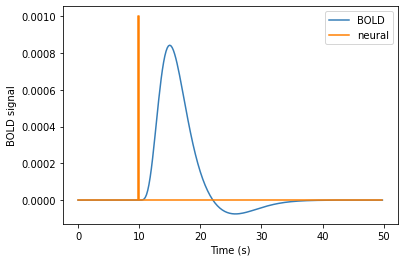

In [2]:
frame_times = np.arange(0, 50, .2)
#Stimulus a 10s, that is instantaneous (0s long) with an amplitude of 1
neural_signal_info = np.array([[10], [0], [1]])
bold_from_short_stimulus, _ = compute_regressor(neural_signal_info,
                                             'spm',
                                             frame_times)
neural_signal = np.zeros(frame_times.shape)
neural_signal[frame_times == neural_signal_info[0,0]] = .001
plt.plot(frame_times, bold_from_short_stimulus, label='BOLD')
plt.step(frame_times, neural_signal, label='neural')
plt.plot
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal')
plt.legend()
plt.show()

There are a few important things to note about the hypothesized BOLD signal.  First, there's always some sort of scaling done by the software after convolution and it varies by software, so don't read much into why the peak is around .0008.  It doesn't really matter unless you want to convert your signal estimates to percent signal change, but that's for another day.  Second it takes about 6 seconds for the BOLD signal to fully build up.  Last, there's a post-stimulus undershoot where the signal dips below baseline before returning to baseline.  For our purposes here it doesn't matter why this is happening, only that it does happen and if we want our models to be accurate, we're better off including it.  

Now, the option we chose, `spm`, corresponds to the SPM HRF is a combination of 2 gamma functions, one gives the main peak and the other gives the undershoot.  Some software packages (FSL and likely AFNI) have a single gamma option, which does not have a post stimulus undershoot.  It is a bad idea to use a single gamma HRF because it can tend to overestimate the signal magnitude and it is noticeable in the results.  Nilearn doesn't have a single gamma, so I won't be illustrating it here.

The other option in Nilearn is the ``glover`` HRF, which is also a double gamma.  We tend to use the `spm` option, but it likely won't make much of a difference in practice.

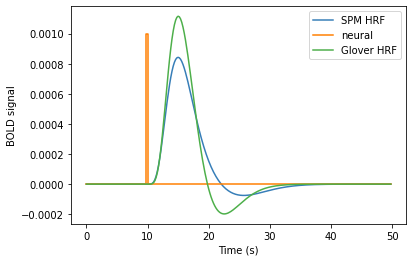

In [3]:
glover_hrf_bold_from_short_stimulus, _ = compute_regressor(neural_signal_info,
                                             'glover',
                                             frame_times)
plt.plot(frame_times, bold_from_short_stimulus, label='SPM HRF')
plt.step(frame_times, neural_signal, label='neural')
plt.plot(frame_times, glover_hrf_bold_from_short_stimulus, label='Glover HRF')
plt.plot
plt.xlabel('Time (s)')
plt.ylabel('BOLD signal')
plt.legend()
plt.show()

## Linear Time Invariance
So, what does ``compute_regressor`` do?  It takes the neuronal signal (orange) and smooshes it together with the HRF shape using an operation called convolution.  If you like equations, this is what it does with the neural signal over time, $n(t)$ and the hrf shape over time, $hrf(t)$:
$$convolved\_signal(t) = \sum_{m=-M}^tn(t-m)*hrf(m).$$
What does this mean?  This is a really sluggish signal, so what we measure right now is a summation of what is happening right now and remaining signal from the past.  

It is easier to understand with a neural signal that is longer than a blip.  I'm going through the summation backwards (starting at m=8)

$$BOLD\_estimate(8) = n(8-8)*hrf(8) + n(8-7)hrf(7) + n(8-6)hrf(6)+ n(8-5)hrf(5) + \dots$$
$$ = n(0)hrf(8) + n(1)hrf(7) + n(2)hrf(6) + n(3)hrf(5) + n(4)hrf(4) + n(5)hrf(3) + n(6)hrf(2) + n(7)hrf(1) + n(8)hrf(0)$$

So contribution from whatever the neuron is doing "right now" is very small since the value of the hrf at time 0 is 0 (see the example below).  What we see now is mostly signal that has built up from the past.  So, in a sense, the BOLD signal is living in the past and telling us nothing about the present time point.  The following plot illustrates convolution.  Note the HRF has been flipped from right to left (this accounts for the t-m part in the convolution operation).  The BOLD signal at 8 seconds is the sum of the heights of all of the stars, which are the products of the HRF height and the neural signal height (0 or 1).  You can see the largest contribution to the current signal, in this case, is a contribution from when the neuron was firing 4s ago.


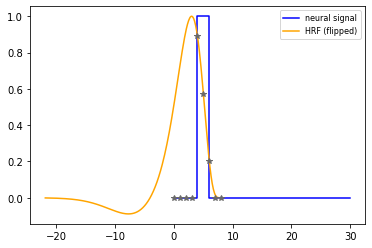

In [4]:
# illustrating convolution in 1s time resolution for time point t=8s
frame_times = np.arange(0, 30, .1)
bold_impulse, _ = compute_regressor(np.array([[0], [0], [1]]),
                                    'spm',
                                    frame_times)
neural_signal = np.zeros(frame_times.shape)
neural_signal[(frame_times>=4) & (frame_times<=6)] = 1

frame_times_flipped_shifted8s_bold = frame_times-(np.max(frame_times) - 8)
flipped_scaled_bold = bold_impulse[::-1]/np.max(bold_impulse)
plt.step(frame_times, neural_signal, color='blue', label='neural signal')
plt.plot(frame_times_flipped_shifted8s_bold, 
         flipped_scaled_bold, color='orange', label='HRF (flipped)')
for ind in range(9):
    plt.plot(ind, neural_signal[frame_times == ind]*
                flipped_scaled_bold[frame_times_flipped_shifted8s_bold == ind],
             '*', color='dimgrey')
plt.legend(loc='upper right', fontsize=8)
plt.show()



In terms of modeling the BOLD signal this we'll see the blurred nature of the signal will be problematic as it can cause collinearity in our models, or correlations between regressors, and is very important to consider when moving a behavioral task into the scanner.  You can get away with quick stimulus presentation in a behavioral study, but in the scanner those quick things are going to blur together and this might be an issue.  Concrete examples will be given shortly and expanded upon more in the next section on study design planning.

Note, you can and should use a much finer time resolution for the convolution operation!  Nilearn's default is to oversample by a factor of 50, meaning if the time resolution of your BOLD data is 1s, it will convolve in 1/50s and then downsample to the TR for modeling purpose.  This ensures the peak is captured well.  It is more important if your TRs are really long (>2s).

An important property of the BOLD signal is that the relationship between BOLD and neuronal signals tends to follow a Linear Time Invariant model, meaning if you shift the neuronal signal in time, the BOLD signal will show this same shift.  If you have two stimuli given one after the other, the resulting signal will be the sum of the two.  If this assumption did not hold, we would not be able to use the convolution operation to build our model regressors.  The following two plots illustrate these points.

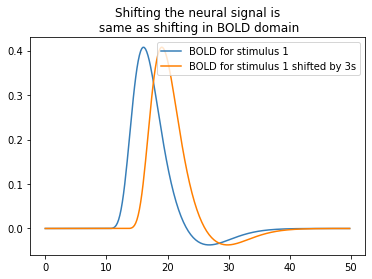

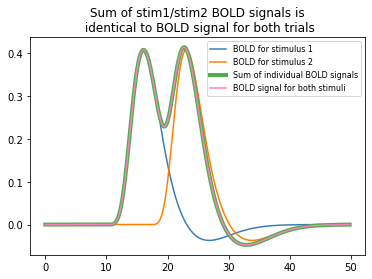

In [5]:
frame_times = np.arange(0, 50, .2)
stim1 = np.array([[10], [2], [1]])
stim2 = np.array([[17], [2], [1]])
stim1_shifted = np.array([[13], [2], [1]])

bold_stim1, _ = compute_regressor(stim1,'spm', frame_times)
bold_stim1_shifted, _ = compute_regressor(stim1_shifted,'spm', frame_times)
plt.plot(frame_times, bold_stim1, label="BOLD for stimulus 1")
plt.plot(frame_times, bold_stim1_shifted, label="BOLD for stimulus 1 shifted by 3s")
plt.legend()
plt.title('Shifting the neural signal is\n same as shifting in BOLD domain')
plt.show()

bold_stim2, _ = compute_regressor(stim2, 'spm', frame_times)
bold_stim1_stim2_sum = bold_stim1 + bold_stim2
stim1_2 = np.concatenate((stim1, stim2), axis=1)
bold_both_stim, _ = compute_regressor(stim1_2, 'spm', frame_times)

plt.plot(frame_times, bold_stim1, label="BOLD for stimulus 1")
plt.plot(frame_times, bold_stim2, label="BOLD for stimulus 2")
plt.plot(frame_times, bold_stim1_stim2_sum, linewidth=4, label="Sum of individual BOLD signals")
plt.plot(frame_times, bold_both_stim, label="BOLD signal for both stimuli")
plt.title('Sum of stim1/stim2 BOLD signals is\n identical to BOLD signal for both trials')
plt.legend(loc='upper right', fontsize=8)
plt.show()

#### Example of a modulated regressor

Sometimes tasks have conditions that we expect will modulate the BOLD activation in a linear fashion.  For example, each trial may have an amount won or lost and our hypothesis is that the BOLD activation will increase, linearly, with this value.  In this case the height of the neural response is simply modulated to match the values of interest.  The following is an example of this.

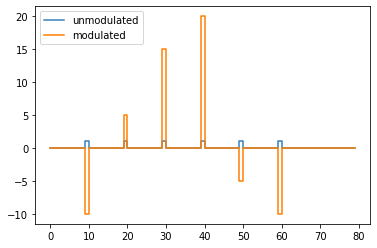

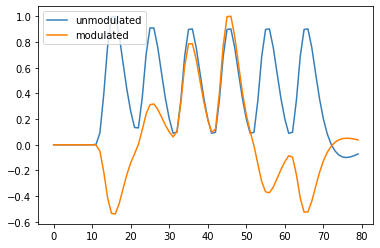

In [6]:
frame_times = np.arange(80)
onsets = np.array([[10, 20, 30, 40, 50, 60]])
vec_1s = np.ones((onsets.shape))
modulation = [[-10, 5, 15, 20, -5, -10]]
unmodulated = np.concatenate((onsets, vec_1s, vec_1s))
modulated = np.concatenate((onsets, vec_1s, modulation))

neural_unmod = np.zeros(len(frame_times))
neural_unmod[onsets] = 1

neural_mod = np.zeros(len(frame_times))
neural_mod[onsets] = modulation

plt.step(frame_times, neural_unmod, label='unmodulated')
plt.step(frame_times, neural_mod, label='modulated')
plt.legend(loc='upper left')
plt.show()



reg_unmodulated, _ = compute_regressor(unmodulated, 'spm', frame_times)
reg_modulated, _ = compute_regressor(modulated, 'spm', frame_times)

plt.plot(frame_times, reg_unmodulated/max(reg_unmodulated), label='unmodulated')
plt.plot(frame_times, reg_modulated/max(reg_modulated), label='modulated')
plt.legend(loc='upper left')
plt.show()

#### What models including RTs look like

Response times are an important consideration in your model if you have button presses.  The preprint to my RT paper is [here](https://www.biorxiv.org/content/10.1101/2023.02.15.528677v1), but there were numerous changes to the manuscript during review.  I'll update the link once I post the final version of the manuscript.

The basic idea is if the duration of the neural activation matches the RT, this will result in larger activation for the longer trials compared to the shorter ones (due to linear time invariance).  A trial that is twice as long as another will have twice the amount of BOLD signal, even when the magnitude of the neural signals is exactly the same.  The following example illustrates a Stroop task analogy where incongruent trials are longer than congruent.  Assuming the true activation magnitude is equal for both conditions, the BOLD magnitude is noticeably larger for the incongruent trials.  The implication is if RTs are ignored, these RT differences will fuel a bias in the incongruent-congruent contrast estimate, resulting in false positives.

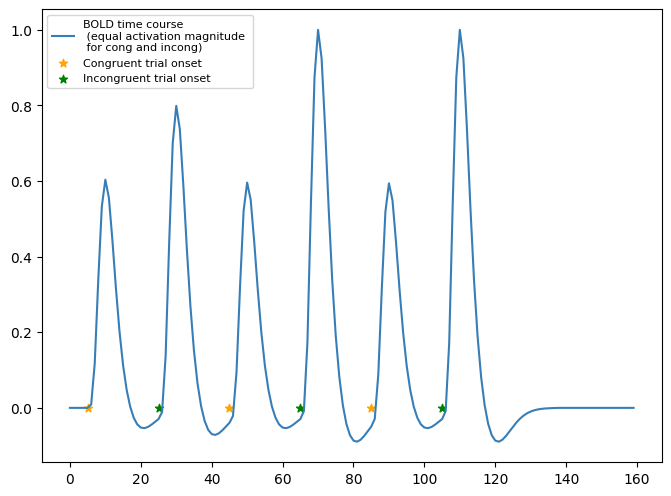

In [7]:
frame_times = np.arange(160)
onset_congruent = np.array([[5, 45, 85]])
onset_incongruent = np.array([[25, 65, 105]])
onsets_all = np.sort(np.concatenate((onset_congruent, onset_incongruent), axis=1))
rts = np.array([[.050, .080, .045, .09, .052, .083]])
rts_centered = rts - .07


congruent = np.concatenate((onset_congruent, np.ones((onset_congruent.shape)), np.ones((onset_congruent.shape))))
incongruent = np.concatenate((onset_incongruent, np.ones((onset_incongruent.shape)), np.ones((onset_incongruent.shape))))
rt_dur = np.concatenate((onsets_all, rts, np.ones((onsets_all.shape))))
rt_mod = np.concatenate((onsets_all, np.ones((onsets_all.shape)), rts_centered))

reg_congruent, _ = compute_regressor(congruent, 'spm', frame_times)
reg_incongruent, _ = compute_regressor(incongruent, 'spm', frame_times)
reg_rt_dur, _ = compute_regressor(rt_dur, 'spm', frame_times)
reg_rt_mod_centered, _ = compute_regressor(rt_mod, 'spm', frame_times)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(frame_times, reg_rt_dur/max(reg_rt_dur), label='BOLD time course \n (equal activation magnitude \n for cong and incong)')
plt.scatter(onset_congruent, np.zeros(onset_congruent.shape), marker='*', color = 'orange', label='Congruent trial onset')
plt.scatter(onset_incongruent, np.zeros(onset_incongruent.shape),  marker='*', color = 'green', label='Incongruent trial onset')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The solution to the above problem is to add in a RT regressor to adjust the BOLD activation comparisons between conditions for the RT differences.  I'm greatly abbreviating the story here and would recommend reading the paper if you'd like the full details.  There are actually more negative repercussions that can result if one ignores RTs in the time series model and these problems cannot be repaired in higher level analyses.

There are two approaches one can take to adding RTs to the model.  One is to simply set the duration of the RT regressor to the individual trial RTs.  Call this model ConsDurRTDur
$$BOLD = \beta_0 + \beta_1 X_{incon} + \beta_2 X_{cong} + \beta_3X_{RTDur} + \epsilon.$$
In this model the interpretation of $\beta_1$  is the incongruent effect magnitude compared to baseline when the RT is 0 (similarly for $\beta_2$).  That's not super helpful, since you cannot have an RT of 0.  That said, it is highly unlikely that this is the primary contrast of interest.  We typically (as far as I know) only look at condition versus baseline contrasts as a reality check, not for heavy scientific purposes.  In the case of the contrast, $\beta_{incong} - \beta_{cong}$, the interpretation is fine, since this difference is the same for all RTs.  This model is, in fact, analogous to a two group comparison adjusting for a single confound.  For example, back in the regression section we compared Wisdom between two groups (does and does not do puzzles), adjusted for age.

For RTs <2s, there is going to be hardly any difference if the RT regressor is set up using duration, as was just outlined, versus using the parametric modulation.  After 2s, this linear relationship fails to hold, so DO NOT use this approach if ANY of your RTs are >2s.  The benefit of using parametric modulation is we can center the RTs prior to convolution.  Importantly, this centering should use the same centering constant for ALL subjects.  The value isn't really all that important, as long as it is within the range of RTs one would expect to find with the task.  You could, for example, use the mean RT for all subjects in your study or even the mean RT reported for that task in a different study.  To fully understand why, let's write out the regression formula and the parameter interpretation:
$$BOLD = \beta_0 + \beta_1 X_{incon} + \beta_2 X_{cong} + \beta_3X_{RTMod - .4s} + \epsilon.$$
Now $\beta_1$ has the interpretation of the incongruent activation versus baseline when the RT was .4s long.  Likewise for $\beta_2$ and $\beta_3$'s interpretation is unchanged.  This isn't a big deal in the case of the Stroop task, since it isn't likely that we'd study this contrast, but other tasks may have condition comparisons where some conditions involve RTs and some do not.  For example, in the Stop Signal task, comparing Correct Go to successful stop might use this strategy since only correct Go trials have an RT.  This task is actually sort of tricky to model and I believe it is much more complicated than this, but that will be left for another day.

Note the constant duration regressors ($X_{incon}$ and $X_{cong}$) can use 1s as the duration.  It doesn't really matter what is chosen as long as it is in the ballpark of the duration and <2s.


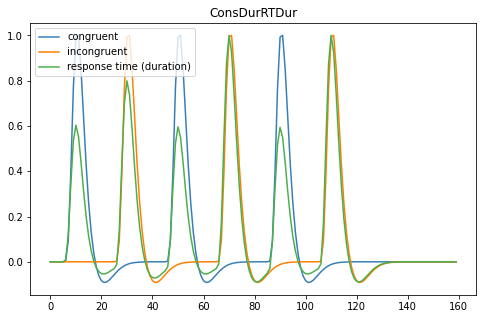

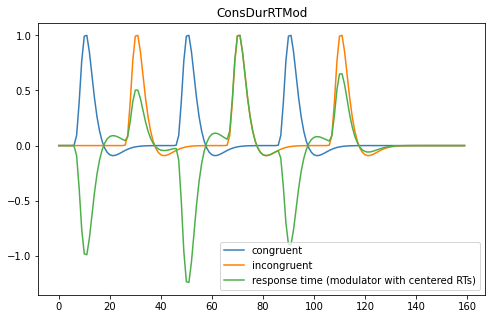

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(frame_times, reg_congruent/max(reg_congruent), label='congruent')
plt.plot(frame_times, reg_incongruent/max(reg_incongruent), label='incongruent')
plt.plot(frame_times, reg_rt_dur/max(reg_rt_dur), label='response time (duration)')
plt.title('ConsDurRTDur')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(frame_times, reg_congruent/max(reg_congruent), label='congruent')
plt.plot(frame_times, reg_incongruent/max(reg_incongruent), label='incongruent')
plt.plot(frame_times, reg_rt_mod_centered/max(reg_rt_mod_centered), label='response time (modulator with centered RTs)')
plt.title('ConsDurRTMod')
plt.legend(loc='lower right')
plt.show()

#### What the derivative does

It is common to enter the derivative terms into the model.  The reason is because the derivative (the change in signal per unit of change in time) can adjust for minor misspecifications of the onset of the trial or the time until when the peak occurs.  Since the HRF can change across the brain and across subjects, this is thought to be useful.  Although it is true that this will help the overall model fit better, it doesn't automatically repair the magnitude estimate used.  We typically still use the original regressor and ignore the derivative.  The repair requires combining the two through a nonlinear relationship (from the Calhoun reference below):
$$amplitude = sign(\hat\beta_{orig})\sqrt{\hat\beta_{orig}^2 + \hat\beta_{deriv}^2}.$$

We rarely actually do this, which makes me wonder whether it is worth it.  It does help reduce the residual, which is helpful, but we can discuss this further when we meet as a group.

I have encountered models where I've had to omit the derivative terms because of collinearity issues.  Although the derivative term is orthogonal to the term it is the derivative of, it can bump into regressors for other conditions.  This is typically only a problem in designs with really fast trial presentations.

The following illustration shows how the sum of the derivative and original regressor can effectively model a shift.  This shift can allow the true amplitude to be captured.  Otherwise, it will be underestimated as the peak will be assumed to be earlier or later.


More can be found in this paper
Calhoun, V.D., Stevens, M.C., Pearlson, G.D., Kiehl, K.A., 2004. fMRI analysis with the general linear model: removal of latency-induced amplitude bias by incorporation of hemodynamic derivative terms. NeuroImage 22, 252–257. https://doi.org/10.1016/j.neuroimage.2003.12.029


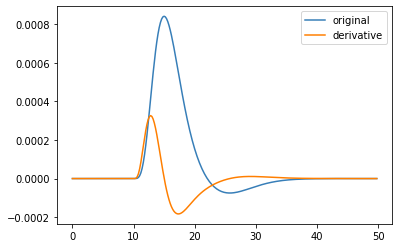

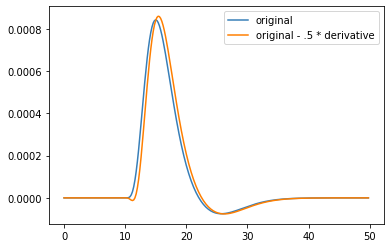

In [9]:
frame_times = np.arange(0, 50, .2)
neural_signal_info = np.array([[10], [0], [1]])
single_stim, names = compute_regressor(neural_signal_info,
                                             'spm + derivative',
                                             frame_times, con_id='single_stim')

plt.plot(frame_times, single_stim[:,0], label='original')
plt.plot(frame_times, single_stim[:,1], label='derivative')
plt.legend(loc='upper right')
plt.show()

plt.plot(frame_times, single_stim[:,0], label='original')
plt.plot(frame_times, single_stim[:,0] - .5 *single_stim[:,1], label='original - .5 * derivative')
plt.legend(loc='upper right')
plt.show()

#### Collinearity


It should be clear, due to the blurring of the signal, why stimuli presented very quickly will be tricky in an fMRI study.  A common occurrence in tasks is to present a stimulus that a subject observes, followed by a cue for the subject to give a response.  Let's assume one is interested in calculating a BOLD effect for when the brain is processing the stimulus as well as when they are shown the cue (when they respond).  For now, response time differences will be ignored, so we will assume it takes the same amount of time to respond on all trials.  

For our model, we will need a regressor that is what we predict the response will look like for the stimulus and then a second regressor that is a prediction for the cue response.  Since we use linear regression, the assumption is the signal in an active voxel will be a scalar multiple of some constant by the regressor we use (our prediction of the time course shape).

In [10]:
def make_desmat_2cond(nstim, name1='stimulus', name2='cue'):
    """
    All design matrices created assume there are 100s of time during which stimuli are presented
    and this time is split equally between the presentation of 2 conditions (stimlus/cue) that alternate. 
    Note, 20s of baseline time is added to the end for a total run time of 120s. 
    The amount of time between the stimlus offset and the cue onset equals the time between the
    cue offset and the next stimulus onset.  The durations of each are 1s long.
    Input:
      nstim: The total number of stimuli (must be divisible by 2), there will be nstim/2
               stimulus/cue pairs
    Output:
      desmat:  A design matrix (pandas 120 x 2) containing the 2 regressors (stimulus/cue)
    """
    if not nstim%2 == 0:
        raise ValueError('nstim must be an even number')
    frame_times = np.arange(120)
    all_onsets = np.linspace(0, 100, nstim)
    cond1_onsets = np.atleast_2d(all_onsets[::2])
    cond2_onsets = np.atleast_2d(all_onsets[1::2])
    vec_1s = np.ones((1, int(nstim/2)))

    #Assuming 1 for both the duration and amplitude
    cond1_reg_data = np.concatenate((cond1_onsets, vec_1s, vec_1s))
    cond2_reg_data = np.concatenate((cond2_onsets, vec_1s, vec_1s))

    reg_cond1, _ = compute_regressor(cond1_reg_data, 'spm', frame_times)
    reg_cond2, _ = compute_regressor(cond2_reg_data, 'spm', frame_times)

    desmat = pd.DataFrame({name1: reg_cond1[:,0], name2: reg_cond2[:,0]})
    return frame_times, desmat

Start off with 50 total condition presentations, which means there's about 1s between the offset of the stimulus and the onset of the cue.  Note the correlation between these two regressors is fairly high.

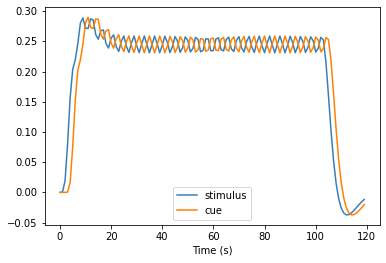

Pearson correlation of regressors
(0.9278461544754527, 2.2573537458409366e-52)


In [11]:
frame_times, desmat = make_desmat_2cond(50, name1='stimulus', name2='cue')
plt.plot(frame_times, desmat['stimulus'], label='stimulus')
plt.plot(frame_times, desmat['cue'], label='cue')
plt.legend()
plt.xlabel('Time (s)')
plt.show()

print('Pearson correlation of regressors')
print(pearsonr(desmat['stimulus'], desmat['cue']))

The above looks a bit dismal, but how high does the correlation need to be to cause problems?  The "problems" in the case of bad collinearity is high variable parameter estimates.  This is easy to see in the case of a perfect collinearity or when two regressors are identical.  Let's say the activation magnitude of the signal is 10, then this model estimation problem is akin to asking many people to give us two numbers that sum to 10.  Obviously there are an infinite number of solutions and this means the variability of value we're told is really high!  This is exactly what happens to the regression parameters:  The variance estimate of the parameter estimates is high.  High variance = low power, so this is a bad situation to be in.  

There's a nice measure called the Variance Inflation Factor (VIF) that quantifies this problem.  It has two really nice properties.  First, it overcomes the major limitation of using the correlation in that it can find collinearities that arise from the relationship between multiple regressors.  For example, the correlations between some regressors $X_1$, $X_2$ and $X_3$ may all be small, but the correlation between $X_1$ and $X_1+X_2$ could be really large.  Here's an example to illustrate this.

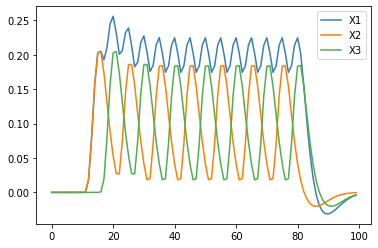

Pairwise correlations are not bad: cor(x1, x2)=0.673, cor(x1, x3)=0.673, cor(x2, x3)=-0.094
Correlation between x1 and x2+x3 is not fine: cor(x1, x2+x3)=1.0!


In [12]:
frame_times = np.arange(100)
onset_1 = np.array([[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]])
onset_2 = np.array([[10, 20, 30, 40, 50, 60, 70]])
onset_3 = np.array([[15, 25, 35, 45, 55, 65, 75]]) 

dat_x1 = np.concatenate((onset_1, np.ones((onset_1.shape)), np.ones((onset_1.shape))))
dat_x2 = np.concatenate((onset_2, np.ones((onset_2.shape)), np.ones((onset_2.shape))))
dat_x3 = np.concatenate((onset_3, np.ones((onset_3.shape)), np.ones((onset_3.shape))))

x_1, _ = compute_regressor(dat_x1, 'spm', frame_times)
x_2, _ = compute_regressor(dat_x2, 'spm', frame_times)
x_3, _ = compute_regressor(dat_x3, 'spm', frame_times)

plt.plot(frame_times, x_1, label='X1')
plt.plot(frame_times, x_2, label='X2')
plt.plot(frame_times, x_3, label='X3')
plt.legend()
plt.show()

cor_x1_x2 = round(pearsonr(x_1[:,0], x_2[:,0])[0], 3)
cor_x1_x3 = round(pearsonr(x_1[:,0], x_3[:,0])[0], 3)
cor_x2_x3 = round(pearsonr(x_2[:,0], x_3[:,0])[0], 3)

cor_x1_sum_x2_and_x3 = round(pearsonr(x_1[:,0], x_2[:,0]+x_3[:,0])[0], 3)


print(f'Pairwise correlations are not bad: cor(x1, x2)={cor_x1_x2}, cor(x1, x3)={cor_x1_x3}, cor(x2, x3)={cor_x2_x3}')
print(f'Correlation between x1 and x2+x3 is not fine: cor(x1, x2+x3)={cor_x1_sum_x2_and_x3}!')




The VIF estimate is obtained for each regressor and uses the $R^2$ from the linear regression regressing the regressor of interest as a function of all of the other regressors.  So if the model has 4 regressors, this is the model that would be used to obtain the VIF for the first regressor (note, we do not use the dependent variable AT ALL).

$$X_1  = \beta_0 + \beta_1X_2 + \beta_2X_3 + \beta_3X_4 + \epsilon.$$

The $R^2$ from this model captures ($R^2_1$) whether any linear combination of regressors can create a new time course that is highly correlated with $X_1$.  The VIF is then given by
$$VIF_{X1} = \frac{1}{1-R_1^2}.$$
The goal is to have a VIF<4.  If it is above 10 you're in trouble.  Above 20 is really bad.  If you do have an elevated VIF for a regressor, you can run the regression from which the $R^2$ used the VIF came from and look at the individual parameter estimates from that model to see which combination of regressors is causing the issue.  Maybe you can omit those regressors or combine stimuli into a single regressor.  The solution typically depends on the cause of the collinearity and there isn't a blanket response for how to fix this issue.  I will say that this should *not* be a problem you're sorting out after you've collected the data.  Nothing is worse than discovering a bad study design after loads of time and money have been invested in collecting the data. We will address this in the next lesson that covers efficiency.

If there's nothing you can do and you're stuck with a high VIF you can (sort of) continue on your merry way.  The analyses are problematic and must be handled very very carefully and I would discourage moving forward with these designs.  Although the parameter estimates for individual subjects are highly variable and won't make much sense on their own, if you average these estimates over subjects you can get statistically valid results (type I errors *shouldn't* be elevated) with a big ding in power.  The big problem is it is *very* easy for the analysis to have outliers and outliers can increase type I errors.  So if this type of analysis is done, the data must be carefully checked for outliers, which is tricky to do in whole brain fMRI analyses.  For group averages it probably isn't too bad, but if one is looking at linear relationships between BOLD activation and subject-specific measures, like the linear relationship between the Stroop effect and age, if the stroop contrast had a really high VIF, this analysis will likely have outliers and the outliers can easily pull that regression line around.  So be careful if you do this.  If I reviewed your paper, I'd make you remove this analysis.  I don't feel it belongs in a publication, personally.  

Perhaps you just noticed I mentioned the VIF for a *contrast*, but I haven't yet explained how to do this. So far we only have VIFs for single parameters!  The VIFs for individual regressors typically isn't all that important when we're estimating contrasts of parameter estimates.  We want the contrasts to have low variability and sometimes two regressors that have high VIFs can yield contrasts that do not have high VIFs.  I've seen some fretting over high VIFs for individual regressors that is (mostly) okay because the contrast of interest does not have a collinearity issue (yay).  I'm not saying it will have wonderful power, but it won't suffer from the wild variability you can see when the VIF is high.

I'm not getting into the nitty gritty of the contrast-based VIF.  I "invented" it by using the ideas of effective regressors from a paper by Smith and others from (2007) (info below).  Basically it splits all of the regressors into two groups: regressors involved in the contrast and regressors not involved in the contrast.  The effective regressor step converts the set of regressors involved in the contrast into one regressor that yields the exact same parameter estimate as the contrast would (the effective regressors) and other, orthogonal, regressors that span the left over space the other contrast-related regressors spanned (the backups).  These are put together with the regressors that were not involved in the contrast to make a model where the parameter estimate (and inference) for the effective regressor exactly matches what one would get for the contrast.  This new model is then entered into the VIF calculation, but only to get the VIF for the effective regressor.  Voila!

Below is an example where the VIFs for the individual regressors isn't great, but the contrast of interest has a totally fine VIF (yay!).  This doesn't necessarily bode well for our overall power, but the contrast estimate will not suffer from the wild variability.


Smith, S., Jenkinson, M., Beckmann, C., Miller, K., Woolrich, M., 2007. Meaningful design and contrast estimability in FMRI. NeuroImage 34, 127–136. https://doi.org/10.1016/j.neuroimage.2006.09.019


In [13]:
def est_vif(desmat):
    '''
    General variance inflation factor estimation.  Calculates VIF for all 
    regressors in the design matrix
    input:
        desmat: design matrix.  Intercept not required.
    output:
      vif_data: Variance inflation factor for each regressor in the design matrix
                generally goal is VIF<5
    '''
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    desmat_with_intercept = desmat.copy()
    desmat_with_intercept['intercept'] = 1
    vif_data = pd.DataFrame()
    vif_data['regressor'] = desmat_with_intercept.columns.drop('intercept')
    vif_data['VIF'] = [variance_inflation_factor(desmat_with_intercept.values, i)
                          for i in range(len(desmat_with_intercept.columns))
                          if desmat_with_intercept.columns[i] != 'intercept']
    return vif_data


def get_eff_reg_vif(desmat, contrast):
    '''
    The goal of this function is to estimate a variance inflation factor for a contrast.
    This is done by extending the effective regressor definition from Smith et al (2007)
    Meaningful design and contrast estimability (NeuroImage).  Regressors involved
    in the contrast estimate are rotated to span the same space as the original space
    consisting of the effective regressor and and an orthogonal basis.  The rest of the 
    regressors are unchanged.
    input:
        desmat: design matrix.  Assumed to be a pandas dataframe with column  
             headings which are used define the contrast of interest
        contrast: a single contrast defined in string format
    output:
        vif: a single VIF for the contrast of interest  
    '''
    from scipy.linalg import null_space
    from nilearn.glm.contrasts import expression_to_contrast_vector
    contrast_def = expression_to_contrast_vector(contrast, desmat.columns)
    des_nuisance_regs = desmat[desmat.columns[contrast_def == 0]]
    des_contrast_regs = desmat[desmat.columns[contrast_def != 0]]

    con = np.atleast_2d(contrast_def[contrast_def != 0])
    con2_t = null_space(con)
    con_t = np.transpose(con)
    x = des_contrast_regs.copy().values
    q = np.linalg.pinv(np.transpose(x)@ x)
    f1 = np.linalg.pinv(con @ q @ con_t)
    pc = con_t @ f1 @ con @ q
    con3_t = con2_t - pc @ con2_t
    f3 = np.linalg.pinv(np.transpose(con3_t) @ q @ con3_t)
    eff_reg = x @ q @ np.transpose(con) @ f1
    eff_reg = pd.DataFrame(eff_reg, columns = [contrast])

    other_reg = x @ q @ con3_t @ f3 
    other_reg_names = [f'orth_proj{val}' for val in range(other_reg.shape[1])]
    other_reg = pd.DataFrame(other_reg, columns = other_reg_names)

    des_for_vif = pd.concat([eff_reg, other_reg, des_nuisance_regs], axis = 1)
    vif_dat = est_vif(des_for_vif)
    vif_dat.rename(columns={'regressor': 'contrast'}, inplace=True)
    vif_output = vif_dat[vif_dat.contrast == contrast]
    return vif_output


def get_all_contrast_vif(desmat, contrasts):
    '''
    Calculates the VIF for multiple contrasts
    input:
        desmat: design matrix.  Pandas data frame, column names must 
                be used in the contrast definitions
        contrasts: A dictionary of contrasts defined in string format
    output:
        vif_contrasts: Data frame containing the VIFs for all contrasts
    '''
    vif_contrasts = {'contrast': [],
                      'VIF': []}
    for key, item in contrasts.items():
        vif_out = get_eff_reg_vif(desmat, item)
        vif_contrasts['contrast'].append(vif_out['contrast'][0])
        vif_contrasts['VIF'].append(vif_out['VIF'][0]) 
    vif_contrasts = pd.DataFrame(vif_contrasts)
    return vif_contrasts     

In [14]:
events = pd.DataFrame({'onset': np.linspace(2, 26,10),
          'duration': [1] * 10,
          'trial_type': ['go', 'nogo'] * 5})
nogo_3col = events.loc[((events['trial_type'] == 'nogo')), ['onset', 'duration'] ]
nogo_3col['amplitude'] = 1
go_3col = events.loc[(events['trial_type'] == 'go') , ['onset', 'duration'] ]
go_3col['amplitude'] = 1

go, go_names = compute_regressor(
        np.transpose(np.array(go_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'go'
    ) 
nogo, nogo_names = compute_regressor(
        np.transpose(np.array(nogo_3col)),
        'spm + derivative',
        np.arange(50),
        con_id = 'nogo'
    ) 
go_pd = pd.DataFrame(go, columns=go_names)
nogo_pd = pd.DataFrame(nogo, columns=nogo_names)

desmat = pd.concat([go_pd, nogo_pd], axis=1)
contrast = {'go - nogo': 'go - nogo',
            'task vs baseline': '.5*go + .5*nogo'}

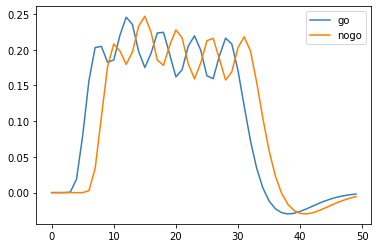

In [15]:
plt.plot(desmat.loc[:,['go', 'nogo']])
plt.legend(['go', 'nogo'])

The individual regressor VIFs do not look good.

In [16]:
vif_desmat = est_vif(desmat)
print(vif_desmat)

         regressor        VIF
0               go  10.120215
1    go_derivative   2.655307
2             nogo  10.178187
3  nogo_derivative   2.461170


But the contrast-specific VIFs are okay.

In [17]:
vif_contrasts = get_all_contrast_vif(desmat, contrast)
print(vif_contrasts)

          contrast       VIF
0        go - nogo  3.226822
1  .5*go + .5*nogo  1.039235


Wait, I think this is more complicated that simply having a low VIF.  It seems like if the go and nogo estimates have high variablity, the difference of the two will also (but the sum wouldn't). To understand better, we can simulate some data sets using the above design and study the behavior of the individual parameters vs the contrast.

We'll iron out the rest in discussion and I'll update this document later!

In [20]:
nsims = 100

go_est =[]
nogo_est = []
go_nogo_est = []
sum_go_nogo = []

for i in range(nsims):
    bold = 2*desmat['go'] + desmat['nogo'] + np.random.normal(loc=0, scale=.1, size=len(desmat['go']))
    desmat['bold'] = bold
    model = smf.ols(formula='bold ~ go + nogo', data=desmat).fit()
    go_loop = model.t_test([0, 1, 0])
    go_est.append(go_loop.effect)
    nogo_loop = model.t_test([0, 0, 1])
    nogo_est.append(nogo_loop.effect)
    go_nogo_loop = model.t_test([0, 1, -1])
    go_nogo_est.append(go_nogo_loop.effect)
    sum_go_nogo_loop = model.t_test([0, 1, 1])
    sum_go_nogo.append(sum_go_nogo_loop.effect)
    
print(f'Go sd of estimates over 100 data sets: {np.std(go_est)}')
print(f'No Go sd of estimates over 100 data sets: {np.std(nogo_est)}')
print(f'G0-NoGO sd of estimates over 100 data sets: {np.std(go_nogo_est)}')
print(f'Go+NoGo sd of estimates over 100 data sets: {np.std(sum_go_nogo)}')

Go sd of estimates over 100 data sets: 0.2582821788820797
No Go sd of estimates over 100 data sets: 0.25172143616572934
G0-NoGO sd of estimates over 100 data sets: 0.49155829420509783
Go+NoGo sd of estimates over 100 data sets: 0.13607782370760615


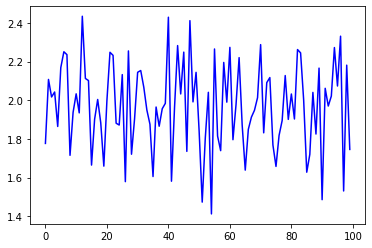

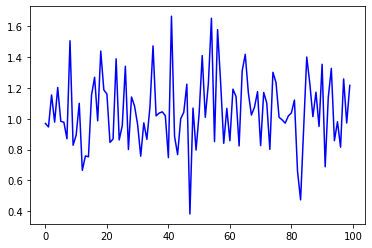

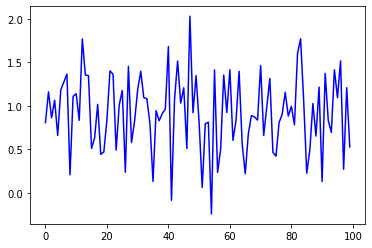

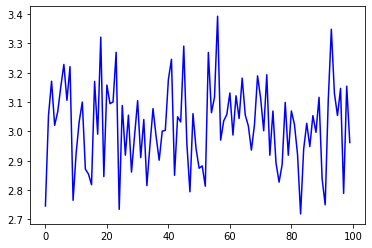

In [19]:
plt.plot(go_est, 'b')
plt.show()

plt.plot(nogo_est, 'b')
plt.show()

plt.plot(go_nogo_est, 'b')
plt.show()

plt.plot(sum_go_nogo, 'b')
plt.show()